<a href="https://colab.research.google.com/github/gmkim71/Mask-R-CNN/blob/main/mask_rcnn_cell_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# The notebooks is self-contained
# It has very few imports
# No external dependencies (only the model weights)
# No train - inference notebooks
# We only rely on Pytorch
import os
import random
import time
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import torch
import torchvision
from torchvision.transforms import ToPILImage
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
# Fix randomness

def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

fix_all_seeds(2021)

In [ ]:
# Reduced the train dataset to 5000 rows
TEST = False

if 'google.colab' in str(get_ipython()):
    # running on CoLab
    from google.colab import drive
    drive.mount('/content/gdrive')
    data_directory = '/content/gdrive/MyDrive/'
    DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    BATCH_SIZE = 2
    NUM_EPOCHS = 50


TRAIN_CSV = f"{'/content/gdrive/MyDrive/sartorius-cell-instance-segmentation'}/train.csv"
TRAIN_PATH = f"{'/content/gdrive/MyDrive/sartorius-cell-instance-segmentation'}/train"
TEST_PATH = f"{'/content/gdrive/MyDrive/sartorius-cell-instance-segmentation'}/test"

WIDTH = 704
HEIGHT = 520

resize_factor = False # 0.5

# Normalize to resnet mean and std if True.
NORMALIZE = False
RESNET_MEAN = (0.485, 0.456, 0.406)
RESNET_STD = (0.229, 0.224, 0.225)

### lr=0.001, USE_SCHEDULER=True, PCT_IMAGES_VALIDATION = 0.2로 변경
MOMENTUM = 0.9
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0005

# Changes the confidence required for a pixel to be kept for a mask.
# Only used 0.5 till now.
# MASK_THRESHOLD = 0.5
# MIN_SCORE = 0.5
# cell type specific thresholds
cell_type_dict = {"astro": 1, "cort": 2, "shsy5y": 3}
mask_threshold_dict = {1: 0.55, 2: 0.75, 3:  0.6}
min_score_dict = {1: 0.55, 2: 0.75, 3: 0.5}

# Use a StepLR scheduler if True.
USE_SCHEDULER = False

# PCT_IMAGES_VALIDATION = 0.2
# PCT_IMAGES_TEST = 0.1

BOX_DETECTIONS_PER_IMG = 540

Mounted at /content/gdrive


In [ ]:
# ref: https://www.kaggle.com/inversion/run-length-decoding-quick-start
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return
    color: color for the mask
    Returns numpy array (mask)

    '''
    s = mask_rle.split()

    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    if len(shape)==3:
        img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
    else:
        img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for start, end in zip(starts, ends):
        img[start : end] = color

    return img.reshape(shape)


#여기가 필요x
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))


def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

def combine_masks(masks, mask_threshold):
    """
    combine masks into one image
    """
    maskimg = np.zeros((HEIGHT, WIDTH))
    # print(len(masks.shape), masks.shape)
    for m, mask in enumerate(masks,1):
        maskimg[mask>mask_threshold] = m
    return maskimg


def get_filtered_masks(pred):
    """
    filter masks using MIN_SCORE for mask and MAX_THRESHOLD for pixels
    """
    use_masks = []
    for i, mask in enumerate(pred["masks"]):

        # Filter-out low-scoring results. Not tried yet.
        scr = pred["scores"][i].cpu().item()
        label = pred["labels"][i].cpu().item()
        if scr > min_score_dict[label]:
            mask = mask.cpu().numpy().squeeze()
            # Keep only highly likely pixels
            binary_mask = mask > mask_threshold_dict[label]
            binary_mask = remove_overlapping_pixels(binary_mask, use_masks)
            use_masks.append(binary_mask)

    return use_masks

In [ ]:
def compute_iou(labels, y_pred, verbose=0):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    if verbose:
        print("Number of true objects: {}".format(true_objects))
        print("Number of predicted objects: {}".format(pred_objects))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    intersection = intersection[1:, 1:] # exclude background
    union = union[1:, 1:]
    union[union == 0] = 1e-9
    iou = intersection / union

    return iou

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [compute_iou(truth, pred, verbose) for truth, pred in zip(truths, preds)]

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)


def get_score(ds, mdl):
    """
    Get average IOU mAP score for a dataset
    """
    mdl.eval()
    iouscore = 0
    for i in tqdm(range(len(ds))):
        img, targets = ds[i]
        with torch.no_grad():
            result = mdl([img.to(DEVICE)])[0]

        masks = combine_masks(targets['masks'], 0.5)
        labels = pd.Series(result['labels'].cpu().numpy()).value_counts()

        mask_threshold = mask_threshold_dict[labels.sort_values().index[-1]]
        pred_masks = combine_masks(get_filtered_masks(result), mask_threshold)
        iouscore += iou_map([masks],[pred_masks])
    return iouscore / len(ds)

In [ ]:
# These are slight redefinitions of torch.transformation classes
# The difference is that they handle the target and the mask
# Copied from Abishek, added new ones
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class VerticalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-2)
            bbox = target["boxes"]
            bbox[:, [1, 3]] = height - bbox[:, [3, 1]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-2)
        return image, target

class HorizontalFlip:
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            target["masks"] = target["masks"].flip(-1)
        return image, target

class Normalize:
    def __call__(self, image, target):
        image = F.normalize(image, RESNET_MEAN, RESNET_STD)
        return image, target

class ToTensor:
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target


def get_transform(train):
    transforms = [ToTensor()]
    if NORMALIZE:
        transforms.append(Normalize())

    # Data augmentation for train
    if train:
        transforms.append(HorizontalFlip(0.5))
        transforms.append(VerticalFlip(0.5))

    return Compose(transforms)

In [ ]:
from torch.utils.data import Dataset

In [ ]:
cell_type_dict = {"astro": 1, "cort": 2, "shsy5y": 3}

class CellDataset(Dataset):
    def __init__(self, image_dir, df, transforms=None, resize=False):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = df

        self.should_resize = resize is not False
        if self.should_resize:
            self.height = int(HEIGHT * resize)
            self.width = int(WIDTH * resize)
            print("image size used:", self.height, self.width)
        else:
            self.height = HEIGHT
            self.width = WIDTH

        self.image_info = collections.defaultdict(dict)
        temp_df = self.df.groupby(["id", "cell_type"])['annotation'].agg(lambda x: list(x)).reset_index()
        for index, row in temp_df.iterrows():
            self.image_info[index] = {
                    'image_id': row['id'],
                    'image_path': os.path.join(self.image_dir, row['id'] + '.png'),
                    'annotations': list(row["annotation"]),
                    'cell_type': cell_type_dict[row["cell_type"]]
                    }

    def get_box(self, a_mask):
        ''' Get the bounding box of a given mask '''
        pos = np.where(a_mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        return [xmin, ymin, xmax, ymax]

    def __getitem__(self, idx):
        ''' Get the image and the target'''

        img_path = self.image_info[idx]["image_path"]
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)

        if self.should_resize:
            img = cv2.resize(img, (self.width, self.height))

        info = self.image_info[idx]

        n_objects = len(info['annotations'])
        masks = np.zeros((len(info['annotations']), self.height, self.width), dtype=np.uint8)
        boxes = []
        labels = []
        for i, annotation in enumerate(info['annotations']):
            a_mask = rle_decode(annotation, (HEIGHT, WIDTH))

            if self.should_resize:
                a_mask = cv2.resize(a_mask, (self.width, self.height))

            a_mask = np.array(a_mask) > 0
            masks[i, :, :] = a_mask

            boxes.append(self.get_box(a_mask))

        # labels
        labels = [int(info["cell_type"]) for _ in range(n_objects)]
        #labels = [1 for _ in range(n_objects)]


        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((n_objects,), dtype=torch.int64)

        # This is the required target for the Mask R-CNN
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.image_info)

In [ ]:
df_base = pd.read_csv(TRAIN_CSV, nrows=5000 if TEST else None)

In [ ]:
df_images = df_base.groupby(["id", "cell_type"]).agg({'annotation': 'count'}).sort_values("annotation", ascending=False).reset_index()

for ct in cell_type_dict:
    ctdf = df_images[df_images["cell_type"]==ct].copy()
    if len(ctdf)>0:
        ctdf['quantiles'] = pd.qcut(ctdf['annotation'], 5)
        display(ctdf.head())

,id,cell_type,annotation,quantiles
5,a7b1db2a42fc,astro,594,"(105.0, 594.0]"
71,903d94c69354,astro,351,"(105.0, 594.0]"
135,2c2cb870da85,astro,174,"(105.0, 594.0]"
138,1ea4e44e5497,astro,164,"(105.0, 594.0]"
139,a75cdb426a8e,astro,163,"(105.0, 594.0]"


,id,cell_type,annotation,quantiles
165,4425efbbacfc,cort,108,"(43.0, 108.0]"
185,4b8dc9c901a6,cort,94,"(43.0, 108.0]"
186,adfd16bee70c,cort,94,"(43.0, 108.0]"
188,76ad9ac01e2d,cort,94,"(43.0, 108.0]"
196,44a154410273,cort,89,"(43.0, 108.0]"


,id,cell_type,annotation,quantiles
0,c4121689002f,shsy5y,790,"(447.8, 790.0]"
1,d164e96bb7a9,shsy5y,782,"(447.8, 790.0]"
2,e748ac1c469b,shsy5y,703,"(447.8, 790.0]"
3,aff8fb4fc364,shsy5y,609,"(447.8, 790.0]"
4,e8ae919aa92e,shsy5y,605,"(447.8, 790.0]"


In [ ]:
df_images.groupby("cell_type").annotation.describe().astype(int)

,count,mean,std,min,25%,50%,75%,max
cell_type,,,,,,,,
astro,131,80,64,5,50,73,100,594
cort,320,33,16,4,23,30,39,108
shsy5y,155,337,149,49,235,324,429,790


In [ ]:
# We used this as a reference to fill BOX_DETECTIONS_PER_IMG=140
df_images[['annotation']].describe().astype(int)

,annotation
count,606
mean,121
std,152
min,4
25%,28
50%,46
75%,140
max,790


In [ ]:
# Use the quantiles of amoount of annotations to stratify
PCT_IMAGES_VALIDATION = 0.2
df_images_train, df_images_val = train_test_split(df_images, stratify=df_images['cell_type'],
                                                  test_size=PCT_IMAGES_VALIDATION,
                                                  random_state=1234)
df_train = df_base[df_base['id'].isin(df_images_train['id'])]
df_val = df_base[df_base['id'].isin(df_images_val['id'])]
print(f"Images in train set:           {len(df_images_train)}")
print(f"Annotations in train set:      {len(df_train)}")
print(f"Images in validation set:      {len(df_images_val)}")
print(f"Annotations in validation set: {len(df_val)}")

Images in train set:           484
Annotations in train set:      58897
Images in validation set:      122
Annotations in validation set: 14688


In [ ]:
# 원하는 비율로 데이터를 나누기
df_images_train, df_images_temp = train_test_split(df_images, test_size=0.3,random_state=1234)
df_images_val, df_images_test = train_test_split(df_images_temp, test_size=0.33,
                                                 random_state=1234)

# train, validation 및 test 데이터프레임 생성
df_train = df_base[df_base['id'].isin(df_images_train['id'])]
df_val = df_base[df_base['id'].isin(df_images_val['id'])]
df_test = df_base[df_base['id'].isin(df_images_test['id'])]


# 데이터셋 크기 출력
print(f"Images in train set:           {len(df_images_train)}")
print(f"Annotations in train set:      {len(df_train)}")
print(f"Images in validation set:      {len(df_images_val)}")
print(f"Annotations in validation set: {len(df_val)}")
print(f"Images in test set:      {len(df_images_test)}")
print(f"Annotations in test set: {len(df_test)}")


Images in train set:           424
Annotations in train set:      53184
Images in validation set:      121
Annotations in validation set: 13599
Images in test set:      61
Annotations in test set: 6802


In [ ]:
ds_train = CellDataset(TRAIN_PATH, df_train, resize=resize_factor, transforms=get_transform(train=True))
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,
                      num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

ds_val = CellDataset(TRAIN_PATH, df_val, resize=resize_factor, transforms=get_transform(train=False))
dl_val = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,
                    num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

#여기만 추가
ds_test = CellDataset(TRAIN_PATH, df_test, resize=resize_factor, transforms=get_transform(train=False))
dl_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,
                    num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
# Override pythorch checkpoint with an "offline" version of the file
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp /content/gdrive/MyDrive/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth

In [ ]:
def get_model(num_classes, model_chkpt=None):
    # This is just a dummy value for the classification head

    if NORMALIZE:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                   box_detections_per_img=BOX_DETECTIONS_PER_IMG,
                                                                   image_mean=RESNET_MEAN,
                                                                   image_std=RESNET_STD)
    else:
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True,
                                                                   box_detections_per_img=BOX_DETECTIONS_PER_IMG)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes+1)

    if model_chkpt:
        model.load_state_dict(torch.load(model_chkpt, map_location=DEVICE))
    return model

# Get the Mask R-CNN model
# The model does classification, bounding boxes and MASKs for individuals, all at the same time
# We only care about MASKS
model = get_model(len(cell_type_dict))
model.to(DEVICE)

# TODO: try removing this for
for param in model.parameters():
    param.requires_grad = True

model.train();

In [ ]:
train_losses = []
validation_losses = []

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, validation_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(validation_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
#optimizer = torch.optim.Adam(params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

n_batches, n_batches_val = len(dl_train), len(dl_val)

validation_mask_losses = []

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Starting epoch {epoch} of {NUM_EPOCHS}")

    time_start = time.time()
    loss_accum = 0.0
    loss_mask_accum = 0.0
    loss_classifier_accum = 0.0
    for batch_idx, (images, targets) in enumerate(dl_train, 1):

        # Predict
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Logging
        loss_mask = loss_dict['loss_mask'].item()
        loss_accum += loss.item()
        loss_mask_accum += loss_mask
        loss_classifier_accum += loss_dict['loss_classifier'].item()

        if batch_idx % 500 == 0:
            print(f"    [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss.item():7.3f}. Mask-only loss: {loss_mask:7.3f}.")

    if USE_SCHEDULER:
        lr_scheduler.step()

    # Train losses
    train_loss = loss_accum / n_batches
    train_loss_mask = loss_mask_accum / n_batches
    train_loss_classifier = loss_classifier_accum / n_batches

    # Validation
    val_loss_accum = 0
    val_loss_mask_accum = 0
    val_loss_classifier_accum = 0

    # 학습 및 검증 손실 기록
    train_losses.append(loss_accum / n_batches)


    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(dl_val, 1):
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

            val_loss_dict = model(images, targets)
            val_batch_loss = sum(loss for loss in val_loss_dict.values())
            val_loss_accum += val_batch_loss.item()
            val_loss_mask_accum += val_loss_dict['loss_mask'].item()
            val_loss_classifier_accum += val_loss_dict['loss_classifier'].item()

    # Validation losses
    val_loss = val_loss_accum / n_batches_val
    val_loss_mask = val_loss_mask_accum / n_batches_val
    val_loss_classifier = val_loss_classifier_accum / n_batches_val
    elapsed = time.time() - time_start

    validation_mask_losses.append(val_loss_mask)

    validation_losses.append(val_loss_accum / n_batches_val)



    torch.save(model.state_dict(), f"pytorch_model-e{epoch}.bin")
    prefix = f"[Epoch {epoch:2d} / {NUM_EPOCHS:2d}]"
    print(prefix)
    print(f"{prefix} Train mask-only loss: {train_loss_mask:7.3f}, classifier loss {train_loss_classifier:7.3f}")
    print(f"{prefix} Val mask-only loss  : {val_loss_mask:7.3f}, classifier loss {val_loss_classifier:7.3f}")
    print(prefix)
    print(f"{prefix} Train loss: {train_loss:7.3f}. Val loss: {val_loss:7.3f} [{elapsed:.0f} secs]")
    print(prefix)

Starting epoch 1 of 50
[Epoch  1 / 50]
[Epoch  1 / 50] Train mask-only loss:   0.408, classifier loss   0.548
[Epoch  1 / 50] Val mask-only loss  :   0.318, classifier loss   0.391
[Epoch  1 / 50]
[Epoch  1 / 50] Train loss:   1.999. Val loss:   1.607 [352 secs]
[Epoch  1 / 50]
Starting epoch 2 of 50
[Epoch  2 / 50]
[Epoch  2 / 50] Train mask-only loss:   0.326, classifier loss   0.382
[Epoch  2 / 50] Val mask-only loss  :   0.313, classifier loss   0.383
[Epoch  2 / 50]
[Epoch  2 / 50] Train loss:   1.612. Val loss:   1.619 [79 secs]
[Epoch  2 / 50]
Starting epoch 3 of 50
[Epoch  3 / 50]
[Epoch  3 / 50] Train mask-only loss:   0.320, classifier loss   0.346
[Epoch  3 / 50] Val mask-only loss  :   0.314, classifier loss   0.362
[Epoch  3 / 50]
[Epoch  3 / 50] Train loss:   1.522. Val loss:   1.514 [78 secs]
[Epoch  3 / 50]
Starting epoch 4 of 50
[Epoch  4 / 50]
[Epoch  4 / 50] Train mask-only loss:   0.316, classifier loss   0.335
[Epoch  4 / 50] Val mask-only loss  :   0.303, classifi

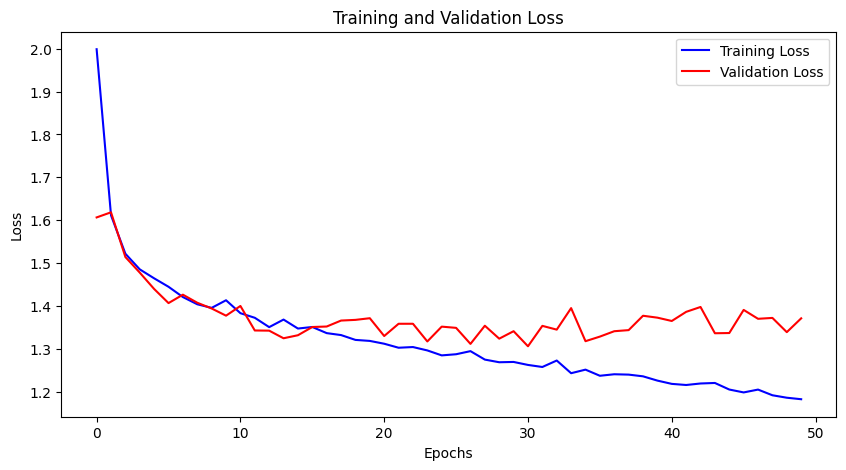

In [ ]:
plot_losses(train_losses, validation_losses)

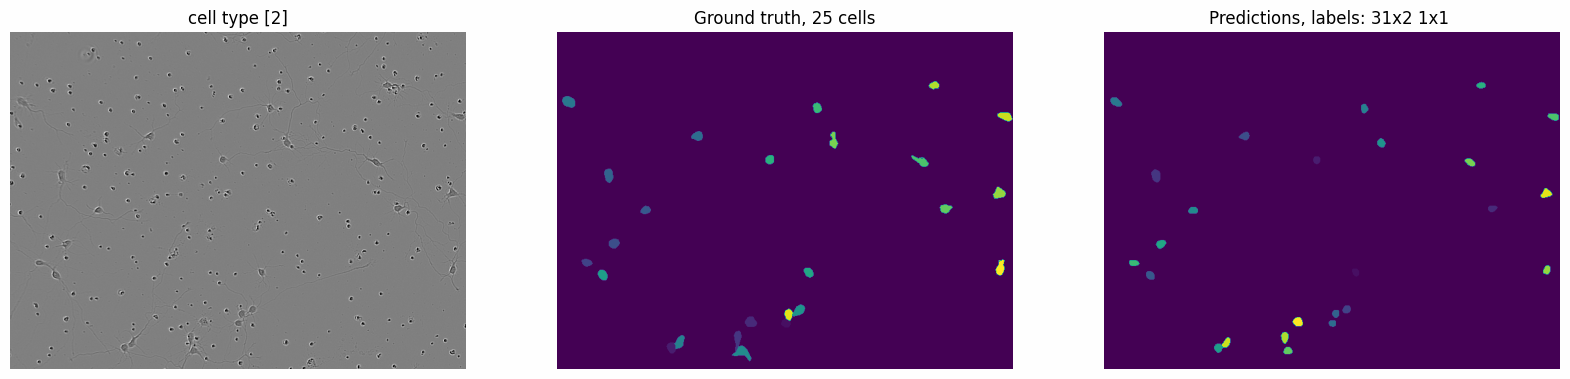

Score: 0.3259999581217712


In [ ]:
# Plots: the image, The image + the ground truth mask, The image + the predicted mask

def analyze_train_sample(model, ds_train, sample_index):

    img, targets = ds_train[sample_index]
    #print(img.shape)
    l = np.unique(targets["labels"])
    ig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,60), facecolor="#fefefe")
    ax[0].imshow(img.numpy().transpose((1,2,0)))
    ax[0].set_title(f"cell type {l}")
    ax[0].axis("off")

    masks = combine_masks(targets['masks'], 0.5)
    #plt.imshow(img.numpy().transpose((1,2,0)))
    ax[1].imshow(masks)
    ax[1].set_title(f"Ground truth, {len(targets['masks'])} cells")
    ax[1].axis("off")

    model.eval()
    with torch.no_grad():
        preds = model([img.to(DEVICE)])[0]

    l = pd.Series(preds['labels'].cpu().numpy()).value_counts()
    lstr = ""
    for i in l.index:
        lstr += f"{l[i]}x{i} "
    #print(l, l.sort_values().index[-1])
    #plt.imshow(img.cpu().numpy().transpose((1,2,0)))
    mask_threshold = mask_threshold_dict[l.sort_values().index[-1]]
    #print(mask_threshold)
    pred_masks = combine_masks(get_filtered_masks(preds), mask_threshold)
    ax[2].imshow(pred_masks)
    ax[2].set_title(f"Predictions, labels: {lstr}")
    ax[2].axis("off")
    plt.show()

    #print(masks.shape, pred_masks.shape)
    score = iou_map([masks],[pred_masks])
    print("Score:", score)


# NOTE: It puts the model in eval mode!! Revert for re-training
analyze_train_sample(model, ds_train, 20)

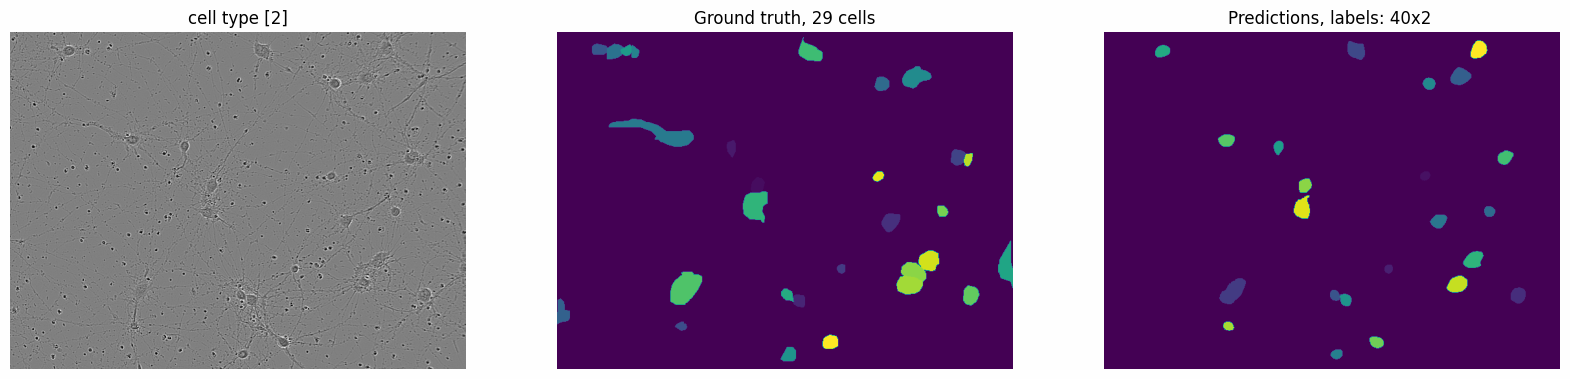

Score: 0.2821861198434386


In [ ]:
analyze_train_sample(model, ds_train, 102)

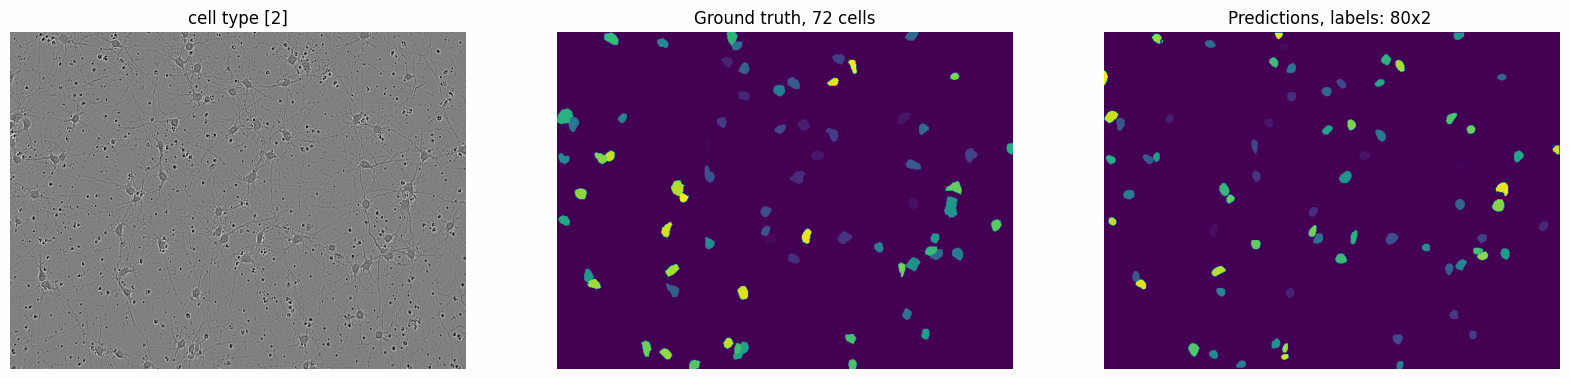

Score: 0.37580538411759606


In [ ]:
analyze_train_sample(model, ds_train, 7)

In [ ]:
# Epochs with their losses and IOU scores

val_scores = pd.DataFrame()
for e, val_loss in enumerate(validation_mask_losses):
    model_chk = f"pytorch_model-e{e+1}.bin"
    print("Loading:", model_chk)
    model = get_model(len(cell_type_dict), model_chk)
    model.load_state_dict(torch.load(model_chk))
    model = model.to(DEVICE)
    val_scores.loc[e,"mask_loss"] = val_loss
    val_scores.loc[e,"score"] = get_score(ds_val, model)


display(val_scores.sort_values("score", ascending=False))

best_epoch = np.argmax(val_scores["score"])
print(best_epoch+1)

In [ ]:
class CellTestDataset(Dataset):
    def __init__(self, image_dir, transforms=None, resize=False):
        self.transforms = transforms
        self.image_dir = image_dir
        self.image_ids = [f[:-4]for f in os.listdir(self.image_dir)]
        self.should_resize = resize is not False
        if self.should_resize:
            self.height = int(HEIGHT * resize)
            self.width = int(WIDTH * resize)
            print("image size used:", self.height, self.width)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + '.png')
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if self.should_resize:
            image = cv2.resize(image, (self.width, self.height))

        if self.transforms is not None:
            image, _ = self.transforms(image=image, target=None)
        return {'image': image, 'image_id': image_id}

    def __len__(self):
        return len(self.image_ids)

In [ ]:
#test dataset에 대한 iou score 표 출력

In [ ]:
def analyze_test_samples(model, ds_test, best_epoch):
    model_chk = f"pytorch_model-e{best_epoch+1}.bin"
    print("Loading:", model_chk)
    model = get_model(len(cell_type_dict))
    model.load_state_dict(torch.load(model_chk))
    model = model.to(DEVICE)

    for param in model.parameters():
        param.requires_grad = False

    # 모든 테스트 샘플에 대한 IOU 점수를 저장할 리스트
    scores = []

    # 각 테스트 샘플에 대해 루프를 실행
    for sample_index in range(len(ds_test)):
        img, targets = ds_test[sample_index]

        model.eval()
        with torch.no_grad():
            preds = model([img.to(DEVICE)])[0]

        # 실제 마스크와 예측된 마스크를 비교하여 IOU 점수 계산
        masks = combine_masks(targets['masks'], 0.5)
        mask_threshold = mask_threshold_dict[preds['labels'].cpu().numpy()[0]]
        pred_masks = combine_masks(get_filtered_masks(preds), mask_threshold)
        score = iou_map([masks], [pred_masks])

        # IOU 점수와 샘플 인덱스 저장
        scores.append((sample_index, score))

    # IOU 점수를 내림차순으로 정렬
    scores.sort(key=lambda x: x[1], reverse=True)

    # 결과를 데이터프레임으로 변환하여 표 형태로 출력
    df_scores = pd.DataFrame(scores, columns=['Sample Index', 'IOU Score'])
    print(df_scores)

# 사용 예시: 최적의 에폭과 테스트 데이터셋을 파라미터로 전달
analyze_test_samples(model, ds_test, best_epoch)


Loading: pytorch_model-e35.bin


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


    Sample Index  IOU Score
0             51   0.620207
1             24   0.545600
2             23   0.534397
3             32   0.525378
4             41   0.501335
..           ...        ...
56            56   0.112430
57            14   0.105835
58            48   0.102006
59            22   0.084546
60            42   0.046250

[61 rows x 2 columns]


In [ ]:
def analyze_test_samples(model, ds_test, best_epoch):
    model_chk = f"pytorch_model-e{best_epoch+1}.bin"
    print("Loading:", model_chk)
    model = get_model(len(cell_type_dict))
    model.load_state_dict(torch.load(model_chk))
    model = model.to(DEVICE)

    for param in model.parameters():
        param.requires_grad = False

    # 모든 테스트 샘플에 대한 IOU 점수를 저장할 리스트
    scores = []

    # 각 테스트 샘플에 대해 루프를 실행
    for sample_index in range(len(ds_test)):
        img, targets = ds_test[sample_index]

        model.eval()
        with torch.no_grad():
            preds = model([img.to(DEVICE)])[0]

        # 실제 마스크와 예측된 마스크를 비교하여 IOU 점수 계산
        masks = combine_masks(targets['masks'], 0.5)
        mask_threshold = mask_threshold_dict[preds['labels'].cpu().numpy()[0]]
        pred_masks = combine_masks(get_filtered_masks(preds), mask_threshold)
        score = iou_map([masks], [pred_masks])

        # IOU 점수와 샘플 인덱스 저장
        scores.append((sample_index, score))

    # IOU 점수를 내림차순으로 정렬
    scores.sort(key=lambda x: x[1], reverse=True)

    # 결과를 데이터프레임으로 변환하여 표 형태로 출력
    df_scores = pd.DataFrame(scores, columns=['Sample Index', 'IOU Score'])

    # 평균과 표준편차 계산
    all_scores = np.array([score[1] for score in scores])
    mean_score = np.mean(all_scores)
    std_score = np.std(all_scores)

    print("Mean IOU Score:", mean_score)
    print("Standard Deviation of IOU Scores:", std_score)

    # 모든 행을 출력
    pd.set_option('display.max_rows', None)
    print(df_scores)

In [ ]:
def analyze_test_samples(model, ds_test, best_epoch):
    model_chk = f"pytorch_model-e{best_epoch+1}.bin"
    print("Loading:", model_chk)
    model = get_model(len(cell_type_dict))
    model.load_state_dict(torch.load(model_chk))
    model = model.to(DEVICE)

    for param in model.parameters():
        param.requires_grad = False

    # 모든 테스트 샘플에 대한 IOU 점수를 저장할 리스트
    scores = []

    # 각 테스트 샘플에 대해 루프를 실행
    for sample_index in range(len(ds_test)):
        img, targets = ds_test[sample_index]

        model.eval()
        with torch.no_grad():
            preds = model([img.to(DEVICE)])[0]

        # 실제 마스크와 예측된 마스크를 비교하여 IOU 점수 계산
        masks = combine_masks(targets['masks'], 0.5)
        mask_threshold = mask_threshold_dict[preds['labels'].cpu().numpy()[0]]
        pred_masks = combine_masks(get_filtered_masks(preds), mask_threshold)
        score = iou_map([masks], [pred_masks])

        # IOU 점수와 샘플 인덱스 저장
        scores.append((sample_index, score))

    # IOU 점수를 내림차순으로 정렬
    scores.sort(key=lambda x: x[1], reverse=True)

    # 결과를 데이터프레임으로 변환하여 표 형태로 출력
    df_scores = pd.DataFrame(scores, columns=['Test Sample Index', 'IOU Score'])

    # 모든 행을 출력
    pd.set_option('display.max_rows', None)
    print(df_scores)

# 사용 예시: 최적의 에폭과 테스트 데이터셋을 파라미터로 전달
analyze_test_samples(model, ds_test, best_epoch)


Loading: pytorch_model-e35.bin


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


    Test Sample Index  IOU Score
0                  51   0.620207
1                  24   0.545600
2                  23   0.534397
3                  32   0.525378
4                  41   0.501335
5                  16   0.497149
6                  17   0.438916
7                  58   0.426257
8                  45   0.423499
9                  46   0.409270
10                  2   0.393533
11                 38   0.374070
12                 55   0.370258
13                 52   0.368962
14                 35   0.366257
15                 26   0.361332
16                 34   0.360700
17                 20   0.342608
18                  5   0.325099
19                 39   0.311944
20                  6   0.300562
21                 19   0.293655
22                 13   0.280501
23                  1   0.272987
24                 25   0.238374
25                 54   0.230234
26                 49   0.227092
27                 33   0.222516
28                 29   0.202622
29        

Loading: pytorch_model-e35.bin


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


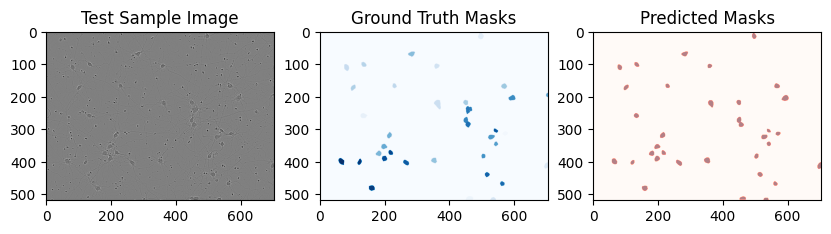

In [ ]:
def visualize_sample_by_index(model, ds_test, sample_index, best_epoch):
    # 모델 로드
    model_chk = f"pytorch_model-e{best_epoch+1}.bin"
    print("Loading:", model_chk)
    model = get_model(len(cell_type_dict))
    model.load_state_dict(torch.load(model_chk))
    model = model.to(DEVICE)

    for param in model.parameters():
        param.requires_grad = False

    # 특정 인덱스의 테스트 이미지 및 타겟 가져오기
    img, targets = ds_test[sample_index]

    model.eval()
    with torch.no_grad():
        result = model([img.to(DEVICE)])[0]

    plt.figure(figsize=(10, 5))

    # Original test image
    plt.subplot(1, 3, 1)
    plt.imshow(img.numpy().transpose((1, 2, 0)))
    plt.title('Test Sample Image')

    # Ground truth masks
    plt.subplot(1, 3, 2)
    masks = combine_masks(targets['masks'], 0.5)
    plt.imshow(masks, cmap='Blues')
    plt.title('Ground Truth Masks')

    # Predicted masks
    plt.subplot(1, 3, 3)
    all_preds_masks = np.zeros((HEIGHT, WIDTH))

    previous_masks = []
    for i, mask in enumerate(result['masks']):
        score = result['scores'][i].cpu().item()
        label = result["labels"][i].cpu().item()

        # 가장 연관성 높은 mask만 남기기
        if score > min_score_dict[label]:
            mask = mask.cpu().numpy()
            binary_mask = mask > mask_threshold_dict[label]
            binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
            previous_masks.append(binary_mask)

        for mask in previous_masks:
            all_preds_masks = np.logical_or(all_preds_masks, mask[0])

    plt.imshow(all_preds_masks, cmap='Reds', alpha=0.5)
    plt.title('Predicted Masks')

    plt.show()


sample_index_to_visualize = 51  # 시각화하려는 score가 가장 큰 테스트 이미지의 idx
visualize_sample_by_index(model, ds_test, sample_index_to_visualize, best_epoch)


Loading: pytorch_model-e35.bin


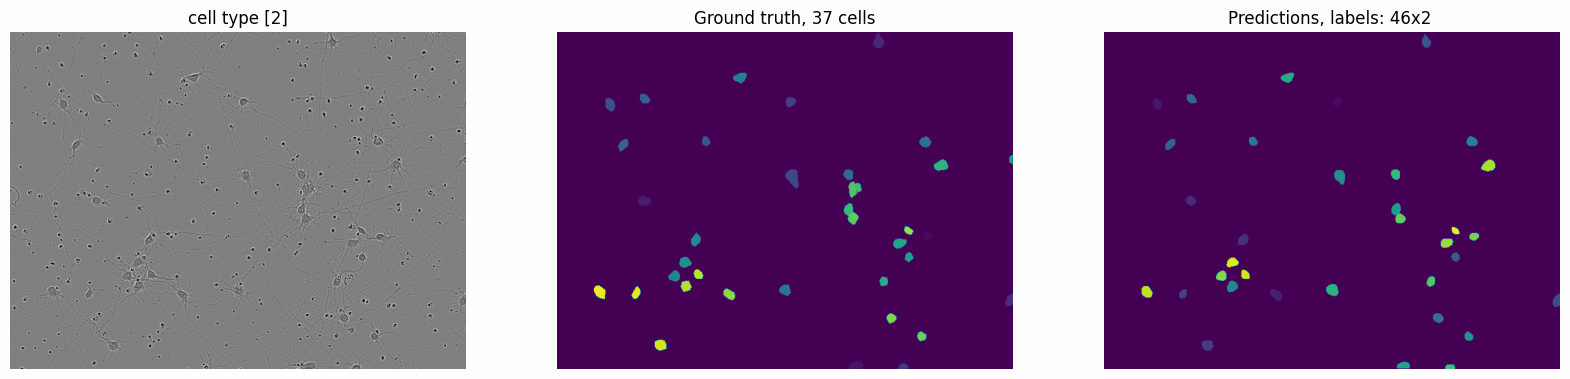

Score: 0.6202069311279838


In [ ]:
def analyze_test_sample(model, ds_test, sample_index):

    model_chk = f"pytorch_model-e{best_epoch+1}.bin"
    print("Loading:", model_chk)
    model = get_model(len(cell_type_dict))
    model.load_state_dict(torch.load(model_chk))
    model = model.to(DEVICE)

    for param in model.parameters():
        param.requires_grad = False

    # model.eval();

    img, targets = ds_test[sample_index]
    #print(img.shape)
    l = np.unique(targets["labels"])
    ig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,60), facecolor="#fefefe")
    ax[0].imshow(img.numpy().transpose((1,2,0)))
    ax[0].set_title(f"cell type {l}")
    ax[0].axis("off")

    masks = combine_masks(targets['masks'], 0.5)
    #plt.imshow(img.numpy().transpose((1,2,0)))
    ax[1].imshow(masks)
    ax[1].set_title(f"Ground truth, {len(targets['masks'])} cells")
    ax[1].axis("off")

    model.eval()
    with torch.no_grad():
        preds = model([img.to(DEVICE)])[0]


    l = pd.Series(preds['labels'].cpu().numpy()).value_counts()
    lstr = ""
    for i in l.index:
        lstr += f"{l[i]}x{i} "
    #print(l, l.sort_values().index[-1])
    #plt.imshow(img.cpu().numpy().transpose((1,2,0)))
    mask_threshold = mask_threshold_dict[l.sort_values().index[-1]]
    #print(mask_threshold)
    pred_masks = combine_masks(get_filtered_masks(preds), mask_threshold)
    ax[2].imshow(pred_masks)
    ax[2].set_title(f"Predictions, labels: {lstr}")
    ax[2].axis("off")
    plt.show()

    #print(masks.shape, pred_masks.shape)
    score = iou_map([masks],[pred_masks])
    print("Score:", score)


# NOTE: It puts the model in eval mode!! Revert for re-training
analyze_test_sample(model, ds_test, 51)

In [ ]:
#이미지 사이즈 확인 위함

In [ ]:
img, targets = ds_test[0]

print(img.shape)

torch.Size([3, 520, 704])


In [ ]:
import sys
print(sys.version)

3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [ ]:
# x, << 전에 test dataset에 anno-없을 때, mask 예측결과 시각화 해보기 위함.

In [ ]:
def visualized_test(ds_test, sample_index):

    # test sample
    img = ds_test[sample_index]['image']
    image_id = ds_test[sample_index]['image_id']
    plt.imshow(img.numpy().transpose((1, 2, 0)))
    plt.title('Test Sample Image')
    plt.show()

    # test predict
    model.eval()

    with torch.no_grad():
        result = model([img.to(DEVICE)])[0]

    plt.imshow(img.numpy().transpose((1, 2, 0)))
    all_preds_masks = np.zeros((HEIGHT, WIDTH))

    previous_masks = []
    for i, mask in enumerate(result['masks']):
        score = result['scores'][i].cpu().item()
        label = result["labels"][i].cpu().item()

        # 가장 연관성 높은 mask만 남기기
        if score > min_score_dict[label]:
            mask = mask.cpu().numpy()
            binary_mask = mask > mask_threshold_dict[label]  # 수정: 해당 라벨의 임계값 사용
            binary_mask = remove_overlapping_pixels(binary_mask, previous_masks)
            previous_masks.append(binary_mask)

        for mask in previous_masks:
            all_preds_masks = np.logical_or(all_preds_masks, mask[0])

    plt.imshow(all_preds_masks, alpha=0.4)
    plt.title('Test Pred')
    plt.show()

visualized_test(ds_test, 1)
